**Model Agnostic Meta Learning**

In [1]:

!pip install git+https://github.com/szagoruyko/pytorchviz

  Cloning https://github.com/szagoruyko/pytorchviz to /private/var/folders/b0/b2chjjqx1gv8kclv1wdjtw840000gn/T/pip-req-build-j0g5t18p
  Created wheel for torchviz: filename=torchviz-0.0.1-py3-none-any.whl size=4340 sha256=893543388862b336a7a703bddad42b94d1ea10971c906613940d9d9ec94d0473
  Stored in directory: /private/var/folders/b0/b2chjjqx1gv8kclv1wdjtw840000gn/T/pip-ephem-wheel-cache-rd12y9dv/wheels/2b/c4/0f/ca56745daf357286cad7d6a34ea87bb22986ae67d01fb35200
Successfully built torchviz
You should consider upgrading via the '/Users/raoniveditha/Documents/CSCI566/assignment3/venv_cs566_hw3/bin/python -m pip install --upgrade pip' command.


In [11]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from torchviz import make_dot, make_dot_from_trace
import torch_maml

**Load Dataset**

In [3]:
# load baa99 file 
baa99_data = pd.read_csv('/Users/raoniveditha/Documents/CSCI566/Project/datasets/baa99_sample4.csv')
# split the data file 
baa99_train, baa99_val = train_test_split(baa99_data, test_size=0.2)

# load landS file 
landS_data = pd.read_csv('/Users/raoniveditha/Documents/CSCI566/Project/datasets/landS_sample4.csv')
# split the data file 
landS_train, landS_val = train_test_split(landS_data, test_size=0.2)

In [4]:
# set up data loader 
batch_size = 40
nworkers = 4
baa99_train_data_loader = torch.utils.data.DataLoader(baa99_train.to_numpy(), batch_size=batch_size, shuffle=True, num_workers=nworkers)
baa99_val_data_loader = torch.utils.data.DataLoader(baa99_val.to_numpy(), batch_size=batch_size, shuffle=True, num_workers=nworkers)

landS_train_data_loader = torch.utils.data.DataLoader(landS_train.to_numpy(), batch_size=batch_size, shuffle=True, num_workers=nworkers)
landS_val_data_loader = torch.utils.data.DataLoader(landS_val.to_numpy(), batch_size=batch_size, shuffle=True, num_workers=nworkers)

Define the task list

In [5]:
# dictionary for the data loader 
train_data_loader = {}
val_data_loader = {}

tasks = ['baa99', 'landS']
train_data_loader['baa99'] = baa99_train_data_loader
train_data_loader['landS'] = landS_train_data_loader

val_data_loader['baa99'] = baa99_val_data_loader
val_data_loader['landS'] = landS_val_data_loader

**Neural Network Config**

In [13]:
# Neural Network Architecture 
# Linear, output units: 40
# ReLU 
# Linear, output units: 1
config = [
    ('linear', [nz, 40]),
    ('relu', [True]),
    ('linear', [40,1])
]
       

In [ ]:
config = [
    ('linear', [nz, 40]),
    ('relu', [True]),
    ('linear', [40,80])
    ('relu', [True]),
    ('linear', [80, 40]),
    ('relu', [True]),
    ('linear', [40,1]),
]

**Test on specialized model**

In [24]:
epoch = 1
learning_rate = 1e-4
nz = 10

# build an neural network model
nn_landS_model = nn_m1(nz)

# set up the optimizer 
opt = torch.optim.Adam(nn_landS_model.parameters(), lr=learning_rate)
criterion = nn.MSELoss() # MSE loss

train_it = 0
loss_record = []
for ep in range(epoch):
  print("Run Epoch {}".format(ep))
  for data in landS_train_data_loader:
    # padding zeros 
    input_size = data.shape[1]
    sample = torch.zeros((batch_size,nz), dtype=torch.float)
    sample[:,:(input_size-1)] = torch.tensor(data[:,:-1], dtype=torch.float)
    h_value = torch.tensor(data[:,5], dtype=torch.float)
    # zero out gradients 
    opt.zero_grad()
    # forward recursion 
    est_h_value = nn_landS_model(sample)
    # loss 
    loss = criterion(est_h_value.view(-1,1), h_value.view(-1,1))
    loss_record.append(loss.item())
    # backward recursion 
    loss.backward()
    # update the weights 
    opt.step()

    if train_it % 100 == 0:
      print("It {}, L2 loss: {} ".format(train_it, loss.item()))
    train_it += 1

# print the loss plot 
plt.plot(loss_record)
plt.title('Training loss (MSE Loss)')
plt.xlabel('Iteration number')
plt.show()

Run Epoch 0


/Users/raoniveditha/Documents/CSCI566/assignment3/venv_cs566_hw3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/raoniveditha/Documents/CSCI566/assignment3/venv_cs566_hw3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Run Epoch 0
It 0, L2 loss: 84649.28125 


/Users/sonny/Documents/Courses/CSCI566/Project/venv_cs566_project/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/sonny/Documents/Courses/CSCI566/Project/venv_cs566_project/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


It 100, L2 loss: 91551.734375 
Run Epoch 1
It 200, L2 loss: 89190.8359375 
It 300, L2 loss: 79344.2890625 
Run Epoch 2
It 400, L2 loss: 68844.9296875 
It 500, L2 loss: 40509.6015625 
Run Epoch 3
It 600, L2 loss: 20384.740234375 
It 700, L2 loss: 4701.70166015625 
Run Epoch 4
It 800, L2 loss: 1519.7071533203125 
It 900, L2 loss: 1673.678466796875 
Run Epoch 5
It 1000, L2 loss: 1456.060546875 
It 1100, L2 loss: 1450.034423828125 
Run Epoch 6
It 1200, L2 loss: 1084.776123046875 
It 1300, L2 loss: 892.845703125 
Run Epoch 7
It 1400, L2 loss: 1129.451904296875 
It 1500, L2 loss: 1028.3416748046875 
Run Epoch 8
It 1600, L2 loss: 730.272705078125 
It 1700, L2 loss: 836.7918090820312 
Run Epoch 9
It 1800, L2 loss: 835.1300048828125 
It 1900, L2 loss: 580.2921142578125 
Run Epoch 10
It 2000, L2 loss: 576.8096923828125 
It 2100, L2 loss: 569.9874267578125 
Run Epoch 11
It 2200, L2 loss: 401.9956970214844 
It 2300, L2 loss: 351.3668212890625 
Run Epoch 12
It 2400, L2 loss: 348.6658935546875 
It 2

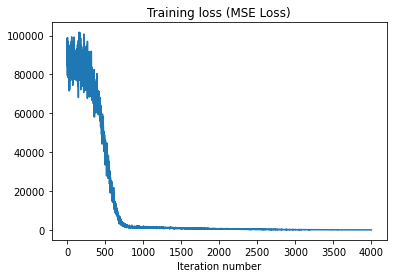

In [ ]:
epoch = 20
learning_rate = 1e-4
nz = 10

# build an neural network model
nn_landS_model = nn_m2(nz)

# set up the optimizer 
opt = torch.optim.Adam(nn_landS_model.parameters(), lr=learning_rate)
criterion = nn.MSELoss() # MSE loss

train_it = 0
loss_record = []
for ep in range(epoch):
  print("Run Epoch {}".format(ep))
  for data in landS_train_data_loader:
    # padding zeros 
    input_size = data.shape[1]
    sample = torch.zeros((batch_size,nz), dtype=torch.float)
    sample[:,:(input_size-1)] = torch.tensor(data[:,:-1], dtype=torch.float)
    h_value = torch.tensor(data[:,5], dtype=torch.float)
    # zero out gradients 
    opt.zero_grad()
    # forward recursion 
    est_h_value = nn_landS_model(sample)
    # loss 
    loss = criterion(est_h_value.view(-1,1), h_value.view(-1,1))
    loss_record.append(loss.item())
    # backward recursion 
    loss.backward()
    # update the weights 
    opt.step()

    if train_it % 100 == 0:
      print("It {}, L2 loss: {} ".format(train_it, loss.item()))
    train_it += 1

# print the loss plot 
plt.plot(loss_record)
plt.title('Training loss (MSE Loss)')
plt.xlabel('Iteration number')
plt.show()

**Model Agnostic Meta Learning Model**

In [ ]:
import torch.nn.functional as F
# Neural Network Architecture 
# Linear, output units: 40
# ReLU 
# Linear, output units: 1

class maml_m1(nn.Module):
    def __init__(self, nz):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(nz, 40, bias=True),
            nn.ReLU(),
            nn.Linear(40, 1, bias=True))
    
    def get_weights(self):
        weights_dict = {}
        for name, parameter in self.net.named_parameters():
            weights_dict[name] = parameter
        return weights_dict
    
    def adapt_forward(self, x, weights_dict):
        x = F.linear(x, weights_dict['0.weight'], weights_dict['0.bias'])
        x = F.relu(x)
        x = F.linear(x, weights_dict['2.weight'], weights_dict['2.bias'])
        return x
    
    def forward(self, x):
        return self.net(x)

In [ ]:
# Neural Network Architecture 
# Linear, output units: 40
# ReLU 
# Linear, output units: 80
# ReLU 
# Linear, output units: 40
# ReLU 
# Linear, output units: 1


class maml_m2(nn.Module):
    def __init__(self, nz):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(nz, 40, bias=True),
            nn.ReLU(),
            nn.Linear(40, 80, bias=True),
            nn.ReLU(),
            nn.Linear(80, 40, bias=True),
            nn.ReLU(),
            nn.Linear(40, 1, bias=True))
    
    def get_weights(self):
        weights_dict = {}
        for name, parameter in self.net.named_parameters():
            weights_dict[name] = parameter
        return weights_dict
    
    def adapt_forward(self, x, weights_dict):
        x = F.linear(x, weights_dict['0.weight'], weights_dict['0.bias'])
        x = F.relu(x)
        x = F.linear(x, weights_dict['2.weight'], weights_dict['2.bias'])
        x = F.relu(x)
        x = F.linear(x, weights_dict['4.weight'], weights_dict['4.bias'])
        x = F.relu(x)
        x = F.linear(x, weights_dict['6.weight'], weights_dict['6.bias'])
        return x
    
    def forward(self, x):
        return self.net(x)

Weights update function in the inner loop (adaptation)

$\theta'_i = \theta - \alpha \nabla_\theta L_{\mathcal{L}_i}(f_\theta) $

In [ ]:
def update_weights(loss, weights_dict, lr):
    new_weights_dict = {}
    grads = {}
    for name in weights_dict:
        grad = torch.autograd.grad(loss, weights_dict[name], retain_graph=True)
        grads[name] = grad[0]
    for name in weights_dict:
        new_weights_dict[name] = weights_dict[name] - lr * grads[name]
    return new_weights_dict

Main Trainging Loop

Update in the outer loop 
$\theta \leftarrow \theta - \beta \nabla_\theta \sum_{i} \mathcal{L}_{\mathcal{T}_i} (f_{\theta'_i})$

In [ ]:
outer_iteration = 200
beta = 1e-5
alpha = 1e-5
nz = 10 # number of input units 

debug_mod = False
maml_model = maml_m1(nz)
maml_model = maml_model.train()
maml_opt = torch.optim.Adam(maml_model.parameters(), lr=beta)

criterion = nn.MSELoss() # MSE loss
loss_record = []
for outer_it in range(outer_iteration):
    outer_loop_total_loss = torch.tensor(0, dtype=torch.float)
    for task in tasks: 
        maml_model.zero_grad() # zero out the gradients 
        cur_weights_dict = None
        new_weights_dict = None
        # inner loop adaptation 
        for data in train_data_loader[task]:
            # padding zeros
            input_size = data.shape[1]
            inner_loop_sample = torch.zeros((batch_size,nz), dtype=torch.float)
            inner_loop_sample[:,:(input_size-1)] = torch.tensor(data[:,:-1], dtype=torch.float)
            # get true h value
            h_value = torch.tensor(data[:,-1], dtype=torch.float)
            # forward recursion 
            est_h_value = maml_model.forward(inner_loop_sample)
            # compute MSE loss 
            inner_loop_loss = criterion(est_h_value.view(-1,1), h_value.view(-1,1))
            # get weight dictionary 
            cur_weights_dict = maml_model.get_weights()
            if debug_mod == True:
                # show the cur_weights_dict (debug: to make sure cur_weights_dict does not change in the inner loop)
                print('It {}, task: {}'.format(outer_it, task))
                print('***MAML weights***')
                print(cur_weights_dict)
            # inner loop update by SGD
            new_weights_dict = update_weights(inner_loop_loss, cur_weights_dict, alpha)
            if debug_mod == True:
                print('***Adapted weights***')
                print(new_weights_dict)
            # only one batch is used in one inner loop
            break
        # calculate adaptation loss 
        for data in val_data_loader[task]:
            # padding zeros 
            input_size = data.shape[1]
            outer_loop_sample = torch.zeros((batch_size,nz), dtype=torch.float)
            outer_loop_sample[:,:(input_size-1)] = torch.tensor(data[:,:-1], dtype=torch.float)
            # get true h value 
            h_value = torch.tensor(data[:,-1], dtype=torch.float)
            # get estimated h value by using the adapted weights 
            est_h_value = maml_model.adapt_forward(outer_loop_sample,new_weights_dict)
            # calculate adaptation loss 
            outer_loop_loss = criterion(est_h_value.view(-1,1), h_value.view(-1,1))
            # add the adaptation loss to the total adaptation loss 
            outer_loop_total_loss += outer_loop_loss
            break
    # record the loss 
    loss_record.append(outer_loop_total_loss)
    # update the weight of MAML model based on the total adaptation loss 
    maml_model.zero_grad()
    outer_loop_total_loss.backward()
    maml_opt.step()
    if outer_it % 50 == 0:
        print('It {}, traning loss: {}'.format(outer_it, outer_loop_total_loss))

/Users/sonny/Documents/Courses/CSCI566/Project/venv_cs566_project/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/sonny/Documents/Courses/CSCI566/Project/venv_cs566_project/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


It 0, traning loss: 82313.375


/Users/sonny/Documents/Courses/CSCI566/Project/venv_cs566_project/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/sonny/Documents/Courses/CSCI566/Project/venv_cs566_project/lib/python3.6/site-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


It 50, traning loss: 84685.765625
It 100, traning loss: 89082.71875
It 150, traning loss: 87889.0703125


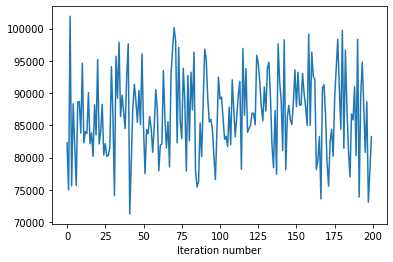

In [ ]:
# print out the loss curve
plt.plot(loss_record)
plt.xlabel('Iteration number')
plt.show()

In [ ]:
outer_iteration = 1000
beta = 1e-4
alpha = 1e-5
nz = 10 # number of input units 

debug_mod = False
maml_model = maml_m2(nz)
maml_model = maml_model.train()
maml_opt = torch.optim.Adam(maml_model.parameters(), lr=beta)

criterion = nn.MSELoss() # MSE loss
loss_record = []
for outer_it in range(outer_iteration):
    outer_loop_total_loss = torch.tensor(0, dtype=torch.float)
    for task in tasks: 
        maml_model.zero_grad() # zero out the gradients 
        cur_weights_dict = None
        new_weights_dict = None
        # inner loop adaptation 
        for data in train_data_loader[task]:
            # padding zeros
            input_size = data.shape[1]
            inner_loop_sample = torch.zeros((batch_size,nz), dtype=torch.float)
            inner_loop_sample[:,:(input_size-1)] = torch.tensor(data[:,:-1], dtype=torch.float)
            # get true h value
            h_value = torch.tensor(data[:,-1], dtype=torch.float)
            # forward recursion 
            est_h_value = maml_model.forward(inner_loop_sample)
            # compute MSE loss 
            inner_loop_loss = criterion(est_h_value.view(-1,1), h_value.view(-1,1))
            # get weight dictionary 
            cur_weights_dict = maml_model.get_weights()
            if debug_mod == True:
                # show the cur_weights_dict (debug: to make sure cur_weights_dict does not change in the inner loop)
                print('It {}, task: {}'.format(outer_it, task))
                print('***MAML weights***')
                print(cur_weights_dict)
            # inner loop update by SGD
            new_weights_dict = update_weights(inner_loop_loss, cur_weights_dict, alpha)
            if debug_mod == True:
                print('***Adapted weights***')
                print(new_weights_dict)
            # only one batch is used in one inner loop
            break
        # calculate adaptation loss 
        for data in val_data_loader[task]:
            # padding zeros 
            input_size = data.shape[1]
            outer_loop_sample = torch.zeros((batch_size,nz), dtype=torch.float)
            outer_loop_sample[:,:(input_size-1)] = torch.tensor(data[:,:-1], dtype=torch.float)
            # get true h value 
            h_value = torch.tensor(data[:,-1], dtype=torch.float)
            # get estimated h value by using the adapted weights 
            est_h_value = maml_model.adapt_forward(outer_loop_sample,new_weights_dict)
            # calculate adaptation loss 
            outer_loop_loss = criterion(est_h_value.view(-1,1), h_value.view(-1,1))
            # add the adaptation loss to the total adaptation loss 
            outer_loop_total_loss += outer_loop_loss
            break
    # record the loss 
    loss_record.append(outer_loop_total_loss)
    # update the weight of MAML model based on the total adaptation loss 
    maml_model.zero_grad()
    outer_loop_total_loss.backward()
    maml_opt.step()
    if outer_it % 50 == 0:
        print('It {}, traning loss: {}'.format(outer_it, outer_loop_total_loss))

/Users/sonny/Documents/Courses/CSCI566/Project/venv_cs566_project/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/sonny/Documents/Courses/CSCI566/Project/venv_cs566_project/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


It 0, traning loss: 85687.4765625


/Users/sonny/Documents/Courses/CSCI566/Project/venv_cs566_project/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/sonny/Documents/Courses/CSCI566/Project/venv_cs566_project/lib/python3.6/site-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


It 50, traning loss: 88456.5546875
It 100, traning loss: 81873.7578125
It 150, traning loss: 81129.265625
It 200, traning loss: 78112.40625
It 250, traning loss: 87879.5859375
It 300, traning loss: 69622.796875
It 350, traning loss: 61281.8515625
It 400, traning loss: 39780.23046875
It 450, traning loss: 17233.419921875
It 500, traning loss: 3620.650390625
It 550, traning loss: 4811.0419921875
It 600, traning loss: 2371.85107421875
It 650, traning loss: 2969.6796875
It 700, traning loss: 3601.994140625
It 750, traning loss: 2850.330322265625
It 800, traning loss: 3163.48876953125
It 850, traning loss: 2277.128173828125
It 900, traning loss: 1942.096923828125
It 950, traning loss: 1925.8560791015625


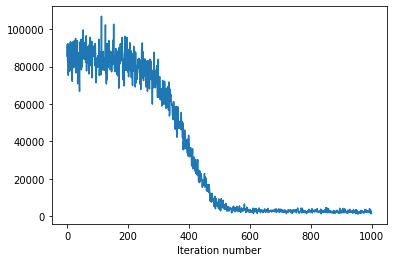

In [ ]:
# print out the loss curve
plt.plot(loss_record)
plt.xlabel('Iteration number')
plt.show()